MNIST data set을 통해 Classification 종류와 모델을 평가하는 방법, 그리고 데이터에 적합한 모델을 셀렉하는 과정에 대해 알아보자. 

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Classification" data-toc-modified-id="Classification-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Classification</a></span><ul class="toc-item"><li><span><a href="#confusion-matrix" data-toc-modified-id="confusion-matrix-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>confusion matrix</a></span></li><li><span><a href="#Precision-and-Recall" data-toc-modified-id="Precision-and-Recall-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Precision and Recall</a></span></li><li><span><a href="#Precision/recall-trade-off" data-toc-modified-id="Precision/recall-trade-off-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Precision/recall trade-off</a></span></li><li><span><a href="#The-ROC-(reciever-operating-characteristic)-Curve" data-toc-modified-id="The-ROC-(reciever-operating-characteristic)-Curve-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>The ROC (reciever operating characteristic) Curve</a></span></li><li><span><a href="#AUC" data-toc-modified-id="AUC-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>AUC</a></span></li><li><span><a href="#Error-Analysis" data-toc-modified-id="Error-Analysis-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Error Analysis</a></span></li><li><span><a href="#Multilabel-Classification" data-toc-modified-id="Multilabel-Classification-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Multilabel Classification</a></span></li><li><span><a href="#Multioutput-Classification" data-toc-modified-id="Multioutput-Classification-2.8"><span class="toc-item-num">2.8&nbsp;&nbsp;</span>Multioutput Classification</a></span></li></ul></li></ul></div>

# Classification

In [1]:
from sklearn.datasets import fetch_openml
import numpy as np

In [2]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

X, y = mnist["data"], mnist["target"]
print("X shape: ", X.shape)
print("y shape: ", y.shape)

X shape:  (70000, 784)
y shape:  (70000,)


* 70000 images
* each images have 784 features
* This is because each image is 28X28
* 0(white) to 255(black)

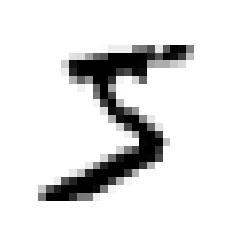

In [47]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [4]:
y[0]

'5'

In [5]:
# y is string, change it to integer as most ML algorithms expect numbers
y = y.astype(np.uint8)

In [6]:
# create training/test set
tr = 60000
X_train, X_test, y_train, y_test = X[:tr], X[tr:], y[:tr], y[tr:]

In [7]:
# for testing, identify one digit
# makes eveyrhing false except 5

y_train_5 = (y_train ==5)
y_test_5 = (y_test == 5)

In [8]:
# SGDClassifier (Stochastic Graident Descent)
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)


SGDClassifier(random_state=42)

In [9]:
sgd_clf.predict([some_digit])

array([ True])

In [10]:
# validation
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [11]:
# not-5 class
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y= None):
        return self
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)
    


In [12]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

* 전체 데이터중 10% 만이 5로 구성 되어 있으므로, 절대 5로 예측하지 않는다고 한다고 하여도 90% 정도의 accuracy를 나타낸다.
* 그러므로 "accuracy"는 Classifiers의 좋은 performance measure가 아니라고 볼 수 있다.
* 특히 위의 예시와 같이 데이터가 skewed된 경우 (when some classes are much more frequent than others)

In [13]:
# K fold prediction
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

## confusion matrix

In [14]:
# confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

* first raw(actual) : non 5s
* second raw(actual) : 5s
* first column(pred) : non 5s
* second column(pred) : 5s

* Precision = $\frac{TP}{TP+FP}$
* Recall/Sensitivity/True Positive Rate(TPR) = $\frac{TP}{TP+FN}

## Precision and Recall

In [15]:
# Precision and Recall
from sklearn.metrics import precision_score, recall_score

pc = precision_score(y_train_5, y_train_pred) #3530/(53892+3530)
rc = recall_score(y_train_5, y_train_pred) #3530/(1891+3530)

print("precision score: ", pc)
print("recall score: ", rc)

precision score:  0.8370879772350012
recall score:  0.6511713705958311


* This means, when the model claims an image represents a 5, it is correct only 83.7% (모델이 5라고 예측한 값들 중, 실제로 5인 경우는 83.7%)
* Also, it only detects 65.1% 5s (5처럼 생긴 여러 모양들 중 65% 정도만 5로 예측)

In [16]:
# F1 score
# Harmonic mean of precision and recall
# Because it gives much more weight to low values, a high F1 will be coming from when both precision and recall are high.

$F1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}}
    = 2 x \frac{precision * recall}{precision+recall}
    = \frac{TP}{TP + \frac{FN+FP}{2}}$

In [17]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

* conext에 따라 precision이 높은 모델, recall이 높은 모델 선택
* 예를들어, 아이들에게 유용한 비디오를 detection에는 high precision (좋은 비디오를 많이 reject -low recall- 하지만 keeps only safe ones -high precision), 소매치기 detection에는 high recall.
* 두 값 다 높을 수는 없는데 이를 precision/recall trade-off라 한다.

## Precision/recall trade-off

In [18]:
# precision/recall trade-off

from sklearn.metrics import precision_recall_curve
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

print("y_score: ", y_scores)
print("precision: ", precisions)
print("recall: ", recalls)
print("thresholds: ", thresholds)

y_score:  [  1200.93051237 -26883.79202424 -33072.03475406 ...  13272.12718981
  -7258.47203373 -16877.50840447]
precision:  [0.09040123 0.09038606 0.09038757 ... 1.         1.         1.        ]
recall:  [1.00000000e+00 9.99815532e-01 9.99815532e-01 ... 3.68935621e-04
 1.84467810e-04 0.00000000e+00]
thresholds:  [-106527.45300471 -105763.22240074 -105406.2965229  ...   38871.26391927
   42216.05562787   49441.43765905]


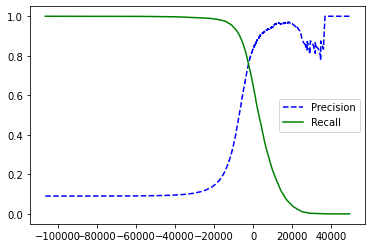

In [19]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend()
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [20]:
# threshold where precision is over 90%
threshold_90_precision = thresholds[np.argmax(precisions>=0.90)]
threshold_90_precision

3370.0194991439557

In [21]:
# to make predictions (on the training set), instead of calling predict() method
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [22]:
pc90 = precision_score(y_train_5, y_train_pred_90)
rc90 = recall_score(y_train_5, y_train_pred_90)

print("pc90: ", pc90)
print("rc90: ", rc90)

pc90:  0.9000345901072293
rc90:  0.4799852425751706


## The ROC (reciever operating characteristic) Curve
* a common tool used with binary classifiers.
* similar to the precision/recall curve
* instead of plotting precision vs recall, it plots the true positive rate(recall) against the false positive rate(FPR)
* FPR: 아닌걸 그렇다고 잘못 판단한 케이스 = 1 - TNR(아닌걸 아니라고 맞게 판단한 케이스)
* TNR is also called specificity
* ROC curve plot = sensitivity(recall) vs (1-specificity)

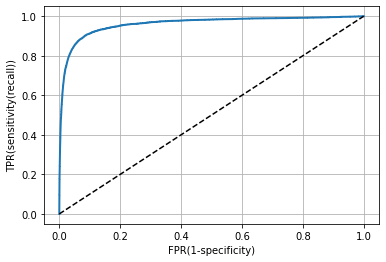

In [23]:
# The ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("FPR(1-specificity)")
    plt.ylabel("TPR(sensitivity(recall))")
    plt.grid()
    
plot_roc_curve(fpr, tpr)
plt.show()

## AUC
* a perfect classifier: ROC AUC = 1 
* a purely random classifier: ROC AUC = 0.5

In [24]:
# measure the area under the curve (AUC)
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

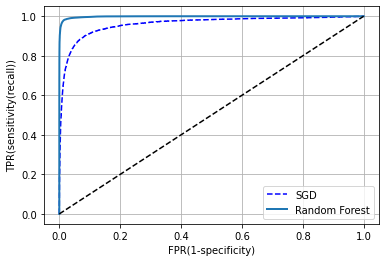

In [25]:
from sklearn.ensemble import RandomForestClassifier
# train random forest
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method = "predict_proba")

# roc_curve() expects labels and scores
# instead of scores, give it class probabilities
# positive classe's probability as the score

y_scores_forest = y_probas_forest[:,1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

# plot ROC curve
plt.plot(fpr,tpr, "b--", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [26]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

* Random Forest Classifier's ROC curve looks much better than the SGDClassifier's
* ROC AUD score is also significantly better

In [29]:
# Multiclass Classification
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [32]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [33]:
np.argmax(some_digit_scores)

5

In [34]:
#When a classifier is trained, it stores the list of target classes in its 'classes_' attribute, orderd by value.
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [35]:
# when you want to forece 'one-versus-one' or 'one-versus-the-rest'
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])
len(ovr_clf.estimaters_)

OneVsRestClassifier(estimator=SVC())

In [36]:
# Training SGDClassifier(or RF Classifier) is just as easy
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [37]:
# Evaluate the classifier
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [40]:
# after scale
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_Scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_Scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## Error Analysis

In [41]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5635,    0,   61,   10,   16,   50,   46,    7,   66,   32],
       [   3, 6393,   95,   21,   16,   47,   15,   27,  109,   16],
       [  72,   56, 5174,   89,   69,   39,  163,   66,  212,   18],
       [  58,   32,  217, 4941,   23,  441,   32,   56,  216,  115],
       [  11,   26,   46,    6, 5298,   26,   73,   32,   87,  237],
       [  68,   23,   58,  150,   83, 4606,  174,   26,  152,   81],
       [  40,   13,   56,    6,   22,  113, 5625,    5,   36,    2],
       [  23,   24,  103,   36,  124,   40,   10, 5228,   75,  602],
       [  40,  101,  158,  122,   49,  457,   77,   35, 4666,  146],
       [  33,   18,   66,   83,  515,  127,    4,  485,  166, 4452]])

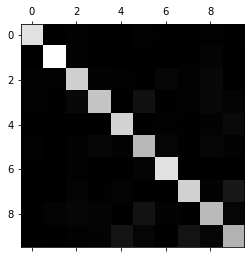

In [42]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

* Most images are classifed correctly
* The 5s looking slightly darker: there are fewer images of 5s in the dataset or the classifier does not perform well on 5s as on other digits.

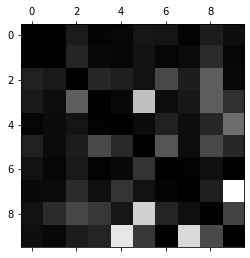

In [44]:
# Error rate instead of absolute numbers of errors
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

* The column for class 8 is quite bright - many images get misclassified as 8s
* The row for class 8 is not that bad - actual 8s in general get properly classified as 8s
* spend some time on reducing the false 8

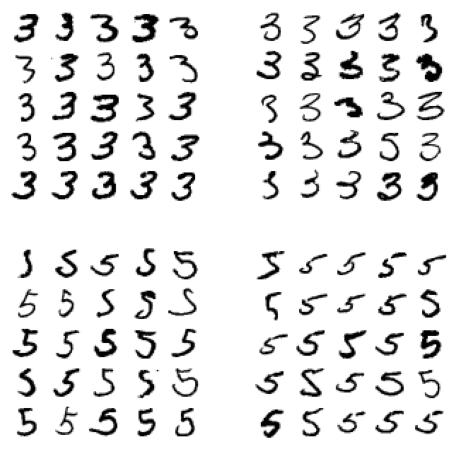

In [52]:
# look into misclassifications
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

cl_a, cl_b = 3,5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

* Using a simple SGDClassifier (linear model) cause lots of misclassifications.

## Multilabel Classification

In [54]:
# e.g) trained for the person A, B and C. when there are only A and C, the output should be [1,0,1] 
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd =(y_train %2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [57]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [58]:
# Evaluate a multilabel classifier
# Compute average F1 score across all labels
# This assume all labels are equally important which may not be the case
# average="weighted" gives more weight to the classifier's score on pictures that have many more than others

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

## Multioutput Classification

In [60]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0,100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

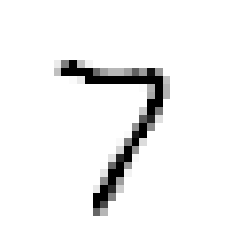

In [64]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digits(clean_digit)

*reference: Hands-on Machine Leraning with Scikit-Learn, Keras & Tensorflow by Aurélien Géron*